### EE 269 Final Project: Data Exploration

Natalie Gable

This notebook contains initial data exploration of the dissolved oxygen dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
import csv
import glob
import os
import glob
import tqdm
import datetime

In [3]:
# import in data
dir_path_files = list(glob.glob(os.path.join("../../do2_data/", "*.csv")))
all_data = {}
it = 0
for csv_file in tqdm.tqdm(dir_path_files):
    this_data = pd.read_csv(csv_file)
    place_name = csv_file[csv_file.find("_data/") + len("_data/"):csv_file.find(".csv")]
    all_data[place_name] = this_data

places = all_data.keys()

# clean up: make sure that there is dissolved oxygen column in dataset
do_date_data = {}
for place in list(places):
    this_frame = all_data[place]
    if "do" not in list(this_frame.columns):
        all_data.pop(place)
    else:
        do_date_data[place] = this_frame[["date", "do"]]

100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


In [4]:
# just extract out readings from 2018
do_places = do_date_data.keys()
do_2018 = {}

for place in do_places:
    datetime = pd.to_datetime(do_date_data[place]['date']).dt.year
    all_2018 = do_date_data[place][datetime == 2018]
    do_2018[place] = all_2018[["date", "do"]]

In [5]:
# need to have the data all be the same length
# need to go from dictionary of frames to one dataframe
do_2018_df = pd.DataFrame()
for place in do_places:
    this_frame = do_2018[place]
    this_frame["place"] = str(place)
    this_frame["day"] = pd.to_datetime(this_frame['date']).dt.date
    this_frame = this_frame.drop_duplicates()
    do_2018_df = do_2018_df.append(this_frame, ignore_index=True)
    print(place, " has ", len(this_frame), "entries")

Rio Vista at Decker Island  has  34761 entries
San Mateo Bridge  has  35040 entries
Mossdale  has  32277 entries
Mallard Island  has  32310 entries
Martinez  has  32288 entries
Miner Slough At Hwy 84 Bridge  has  0 entries
Grizzly Bay A Suisun Slough Nr Avon  has  33906 entries
Delta Cross Channel  has  34613 entries
Sacramento River at Freeport  has  35019 entries
Sacramento River at Mallard Island  has  21855 entries
Pond A8 Outlet  has  35040 entries
Coyote Creek at Alviso Slough  has  35040 entries
Newark Slough  has  35040 entries
Cache Slough  has  32246 entries
Liberty Cut  has  34992 entries
Deep Water Shipping Channel  has  59195 entries
Cache Slough at Liberty Island  has  34887 entries
San Joaquin River at Jersey Point  has  32767 entries
Mowry Slough  has  35040 entries
Prisoner Point  has  32175 entries
Alviso Slough  has  35040 entries
Guadalupe Slough  has  35040 entries
Dumbarton Bridge  has  35040 entries


In [6]:
do_2018_df = do_2018_df[["place", "day", "do"]]
do_2018_day = pd.DataFrame(do_2018_df.groupby(["place", "day"])["do"].apply(list))

In [7]:
# put everything into numpy format
num_entries = 0
for row in do_2018_day.iterrows():
    do = row[1][0]
    if len(do) == 96:
        num_entries += 1

data_X = np.zeros((num_entries, 96))
data_y = np.zeros(num_entries)
data_y_date = np.zeros(num_entries)
it = 0
for row in do_2018_day.iterrows():
    place = row[0][0]
    day = row[0][1]
    do = row[1][0]
    if len(do) == 96:
        data_X[it, :] = np.array(do)
        data_y[it] = list(do_places).index(place)
        it += 1
        
# set nan values to 0
row_means = np.nanmean(data_X, axis = 1)
nan_idx = np.where(np.isnan(data_X))[0]
data_X[np.isnan(data_X)] = row_means[nan_idx]
data_X[np.isnan(data_X)] = 0

/Users/nataliegable/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


In [8]:
# now we want to remove the rows with just nan (now 0) readings
zero_sig_idx = np.zeros(548, dtype=int)
it = 0
for i in range(data_X.shape[0]):
    if np.all(data_X[i,:] == np.zeros(96)):
        zero_sig_idx[it] = i
        it += 1
cleaned_data_X = np.delete(data_X, zero_sig_idx, axis = 0)
cleaned_data_y = np.delete(data_y, zero_sig_idx, axis = 0)

In [9]:
print(cleaned_data_X.shape)
print(data_X.shape)

(6372, 96)
(6920, 96)


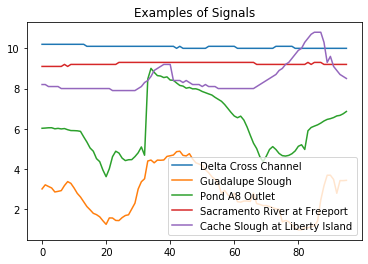

In [14]:
# now let's take a look at some examples in our data
sample_idx = np.random.randint(0, 6372, 5)
for i in sample_idx:
    place = list(do_places)[int(cleaned_data_y[i])]
    plt.plot(cleaned_data_X[i, :], label=place)

plt.title("Examples of Signals")
plt.legend(loc='best')
plt.show()

In [53]:
np.save("data_X.npy", cleaned_data_X)
np.save("data_y.npy", cleaned_data_y)